In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset


class MineralDataset(Dataset):
    def __init__(self, img_dir_al, img_dir_ca, img_dir_mg, labels_csv, transform=None):
        self.dataframe = pd.read_csv(labels_csv)
        self.img_dir_al = img_dir_al
        self.img_dir_ca = img_dir_ca
        self.img_dir_mg = img_dir_mg
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        file_name = row['Segmented Filename']
        label = row['Class']
        img_al = Image.open(os.path.join(self.img_dir_al, file_name)).convert('L')
        img_ca = Image.open(os.path.join(self.img_dir_ca, file_name)).convert('L')
        img_mg = Image.open(os.path.join(self.img_dir_mg, file_name)).convert('L')
        img_combined = Image.merge('RGB', (img_al, img_ca, img_mg))
        if self.transform:
            img_combined = self.transform(img_combined)
        return img_combined, label
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),       
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#Combined Data set
dataset_train = MineralDataset(
    img_dir_al='/Mineral/Enhanced-Al-S',
    img_dir_ca='/Mineral/Ca-S',
    img_dir_mg='/Mineral/Mg-S',
    labels_csv='/Mineral/train_split.csv',  
    transform=transform_train
)

dataset_val = MineralDataset(
    img_dir_al='/Mineral/Enhanced-Al-S',
    img_dir_ca='/Mineral/Ca-S',
    img_dir_mg='/Mineral/Mg-S',
    labels_csv='/Mineral/val_split.csv',
    transform=transform_test
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import copy


resnet34 = models.resnet34(pretrained=True)

for param in resnet34.parameters():
    param.requires_grad = False


num_classes = 3  
num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs, num_classes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet34 = resnet34.to(device)


labels = [label for _, label in dataset_train]  
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(resnet34.fc.parameters(), lr=0.0001)  


def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=200, device='cuda'):
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
  
        model.train()
        train_loss = 0.0
        train_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

      
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
trained_model, training_history = train_and_evaluate_model(resnet34, train_loader, val_loader, criterion, optimizer, num_epochs=200, device=device)


C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/200 - Train Loss: 1.1053, Train Acc: 0.4377, Val Loss: 1.0662, Val Acc: 0.4247
Epoch 2/200 - Train Loss: 1.0512, Train Acc: 0.4663, Val Loss: 1.0169, Val Acc: 0.5685
Epoch 3/200 - Train Loss: 0.9952, Train Acc: 0.6136, Val Loss: 0.9754, Val Acc: 0.5890
Epoch 4/200 - Train Loss: 0.9458, Train Acc: 0.6048, Val Loss: 0.9444, Val Acc: 0.6918
Epoch 5/200 - Train Loss: 0.9228, Train Acc: 0.6613, Val Loss: 0.9157, Val Acc: 0.6678
Epoch 6/200 - Train Loss: 0.9100, Train Acc: 0.6400, Val Loss: 0.8952, Val Acc: 0.6815
Epoch 7/200 - Train Loss: 0.8639, Train Acc: 0.6796, Val Loss: 0.8776, Val Acc: 0.7055
Epoch 8/200 - Train Loss: 0.8499, Train Acc: 0.7082, Val Loss: 0.8631, Val Acc: 0.6986
Epoch 9/200 - Train Loss: 0.8372, Train Acc: 0.7163, Val Loss: 0.8513, Val Acc: 0.7397
Epoch 10/200 - Train Loss: 0.8288, Train Acc: 0.7045, Val Loss: 0.8445, Val Acc: 0.7226
Epoch 11/200 - Train Loss: 0.8064, Train Acc: 0.7192, Val Loss: 0.8354, Val Acc: 0.7432
Epoch 12/200 - Train Loss: 0.8048, Train 

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_predictions_and_labels(model, loader, device):
    model.eval()  
    predictions = []
    labels = []
    with torch.no_grad():
        for inputs, actuals in loader:
            inputs = inputs.to(device)
            actuals = actuals.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            labels.extend(actuals.cpu().numpy())
    return predictions, labels


val_predictions, val_labels = get_predictions_and_labels(trained_model, val_loader, device)


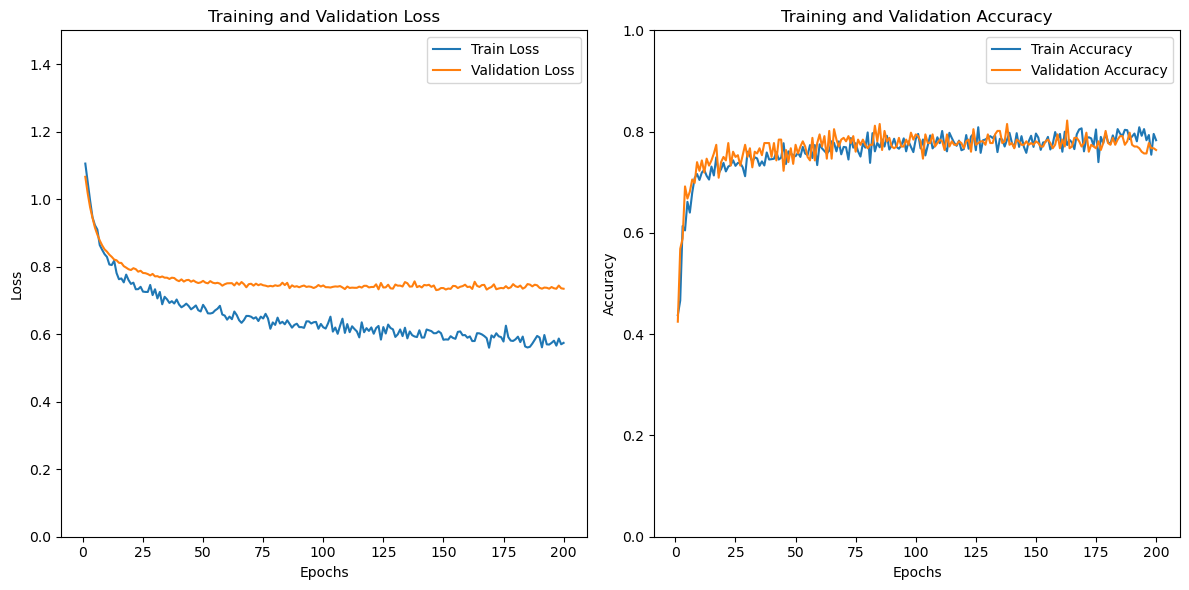

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    
    train_losses = [x.cpu().numpy() if torch.is_tensor(x) else x for x in history['train_loss']]
    val_losses = [x.cpu().numpy() if torch.is_tensor(x) else x for x in history['val_loss']]
    train_accs = [x.cpu().numpy() if torch.is_tensor(x) else x for x in history['train_acc']]
    val_accs = [x.cpu().numpy() if torch.is_tensor(x) else x for x in history['val_acc']]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylim(0, 1.5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(training_history)

# TEST SET

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import copy
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, recall_score, precision_score



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('/Mineral/E1.path')
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

img_dir_al = '/Mineral/Enhanced-Al-S'
img_dir_ca = '/Mineral/Ca-S'
img_dir_mg = '/Mineral/Mg-S'
test_csv = '/Mineral/test_split.csv'

test_dataset = MineralDataset(img_dir_al, img_dir_ca, img_dir_mg, test_csv, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate_model(model, data_loader, criterion, device):
    model.eval()  
    all_probs = []
    all_labels = []
    all_losses = []

    with torch.no_grad():  
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probabilities = torch.softmax(outputs, dim=1)
            all_probs.append(probabilities.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_losses.append(loss.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    all_losses = np.array(all_losses)
    return all_probs, all_labels, all_losses

def bootstrap_metric(y_true, y_prob, metric_func, n_bootstrap=1000, alpha=0.05, **kwargs):
    rng = np.random.default_rng()
    indices = np.arange(len(y_true))
    bootstrapped_scores = []
    for _ in range(n_bootstrap):
        sample_indices = rng.choice(indices, size=len(indices), replace=True)
        if metric_func == roc_auc_score:
            score = metric_func(y_true[sample_indices], y_prob[sample_indices], **kwargs)
        else:
            y_pred = np.argmax(y_prob[sample_indices], axis=1)
            score = metric_func(y_true[sample_indices], y_pred, **kwargs)
        bootstrapped_scores.append(score)
    sorted_scores = np.sort(bootstrapped_scores)
    ci_lower = sorted_scores[int((alpha/2) * n_bootstrap)]
    ci_upper = sorted_scores[int((1 - alpha/2) * n_bootstrap)]
    return np.mean(bootstrapped_scores), ci_lower, ci_upper

def bootstrap_loss(losses, n_bootstrap=1000, alpha=0.05):
    rng = np.random.default_rng()
    indices = np.arange(len(losses))
    bootstrapped_losses = []
    for _ in range(n_bootstrap):
        sample_indices = rng.choice(indices, size=len(indices), replace=True)
        sample_loss = losses[sample_indices]
        bootstrapped_losses.append(np.mean(sample_loss))
    sorted_losses = np.sort(bootstrapped_losses)
    ci_lower = sorted_losses[int((alpha/2) * n_bootstrap)]
    ci_upper = sorted_losses[int((1 - alpha/2) * n_bootstrap)]
    return np.mean(bootstrapped_losses), ci_lower, ci_upper

test_probs, test_labels, test_losses = evaluate_model(model, test_loader, criterion, device)

# 95% CI Calculation
class_labels = np.unique(test_labels)
metrics = {}
for class_label in class_labels:
    auc_roc_mean, auc_roc_ci_low, auc_roc_ci_high = bootstrap_metric(test_labels == class_label, test_probs[:, class_label], roc_auc_score)
    balanced_acc_mean, balanced_acc_ci_low, balanced_acc_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: balanced_accuracy_score(y_true == class_label, y_pred == class_label))
    sensitivity_mean, sensitivity_ci_low, sensitivity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: recall_score(y_true == class_label, y_pred == class_label, zero_division=0))
    specificity_mean, specificity_ci_low, specificity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: precision_score(y_true == class_label, y_pred == class_label, zero_division=0))

    metrics[class_label] = {
        "AUC-ROC": (auc_roc_mean, auc_roc_ci_low, auc_roc_ci_high),
        "Balanced Accuracy": (balanced_acc_mean, balanced_acc_ci_low, balanced_acc_ci_high),
        "Sensitivity": (sensitivity_mean, sensitivity_ci_low, sensitivity_ci_high),
        "Specificity": (specificity_mean, specificity_ci_low, specificity_ci_high)
    }

print("Class\t\tAUC-ROC\t\t\tBalanced Accuracy\tSensitivity\t\tSpecificity")
for class_label, metric_values in metrics.items():
    auc_roc = metric_values["AUC-ROC"]
    balanced_acc = metric_values["Balanced Accuracy"]
    sensitivity = metric_values["Sensitivity"]
    specificity = metric_values["Specificity"]
    print(f"{class_label}\t\t{auc_roc[0]:.2f} ({auc_roc[1]:.2f}-{auc_roc[2]:.2f})\t"
          f"{balanced_acc[0]:.2f} ({balanced_acc[1]:.2f}-{balanced_acc[2]:.2f})\t"
          f"{sensitivity[0]:.2f} ({sensitivity[1]:.2f}-{sensitivity[2]:.2f})\t"
          f"{specificity[0]:.2f} ({specificity[1]:.2f}-{specificity[2]:.2f})")

auc_roc_mean, auc_roc_ci_low, auc_roc_ci_high = bootstrap_metric(test_labels, test_probs, roc_auc_score, multi_class='ovr')
balanced_acc_mean, balanced_acc_ci_low, balanced_acc_ci_high = bootstrap_metric(test_labels, test_probs, balanced_accuracy_score)
sensitivity_mean, sensitivity_ci_low, sensitivity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro', zero_division=0))
specificity_mean, specificity_ci_low, specificity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro', zero_division=0))


loss_mean, loss_ci_low, loss_ci_high = bootstrap_loss(test_losses)

print(f"Overall\t\t{auc_roc_mean:.2f} ({auc_roc_ci_low:.2f}-{auc_roc_ci_high:.2f})\t"
      f"{balanced_acc_mean:.2f} ({balanced_acc_ci_low:.2f}-{balanced_acc_ci_high:.2f})\t"
      f"{sensitivity_mean:.2f} ({sensitivity_ci_low:.2f}-{sensitivity_ci_high:.2f})\t"
      f"{specificity_mean:.2f} ({specificity_ci_low:.2f}-{specificity_ci_high:.2f})")
print(f"Loss\t\t{loss_mean:.4f} ({loss_ci_low:.4f}-{loss_ci_high:.4f})")

Class		AUC-ROC			Balanced Accuracy	Sensitivity		Specificity
0		0.93 (0.89-0.96)	0.86 (0.82-0.90)	0.81 (0.73-0.89)	0.82 (0.74-0.90)
1		0.89 (0.85-0.93)	0.82 (0.77-0.86)	0.79 (0.72-0.85)	0.88 (0.83-0.93)
2		0.68 (0.57-0.79)	0.60 (0.51-0.70)	0.33 (0.16-0.52)	0.19 (0.09-0.30)
Overall		0.83 (0.79-0.88)	0.65 (0.58-0.72)	0.65 (0.57-0.72)	0.63 (0.59-0.68)
Loss		0.6279 (0.5258-0.7413)


In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_predictions_and_labels(model, test_loader, device):
    model.eval() 
    predictions = []
    labels = []
    with torch.no_grad():
        for inputs, actuals in test_loader:
            inputs = inputs.to(device)
            actuals = actuals.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            labels.extend(actuals.cpu().numpy())
    return predictions, labels

test_predictions, test_labels = get_predictions_and_labels(trained_model, test_loader, device)


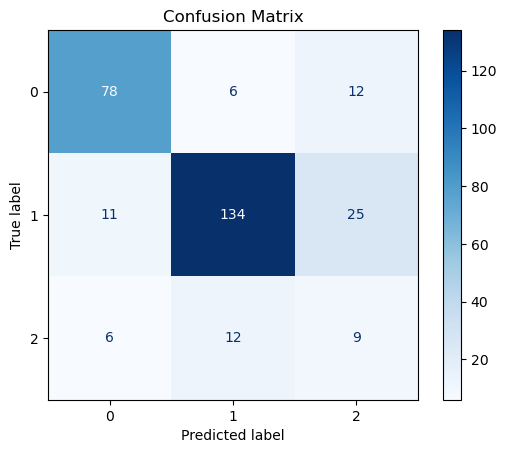

              precision    recall  f1-score   support

     Class 0       0.82      0.81      0.82        96
     Class 1       0.88      0.79      0.83       170
     Class 2       0.20      0.33      0.25        27

    accuracy                           0.75       293
   macro avg       0.63      0.64      0.63       293
weighted avg       0.80      0.75      0.77       293



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

test_predictions, test_labels = get_predictions_and_labels(trained_model, test_loader, device)

cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_labels, test_predictions, target_names=['Class 0', 'Class 1', 'Class 2']))


In [ ]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle

def evaluate_model_for_roc(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()

    all_preds_prob = []
    all_labels = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_preds_prob.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds_prob = np.concatenate(all_preds_prob)
    all_labels = np.concatenate(all_labels)

    return all_preds_prob, all_labels

num_classes = 3
all_preds_prob, all_labels = evaluate_model_for_roc(trained_model, test_loader, device=device)
all_labels_one_hot = label_binarize(all_labels, classes=[0, 1, 2])


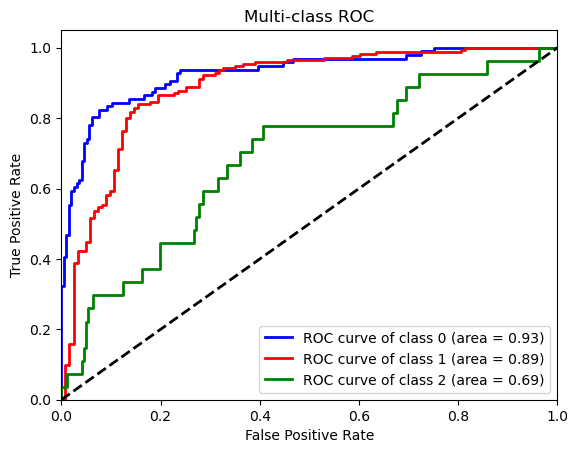

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], all_preds_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def get_predictions(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
            predictions.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

# Get predictions and true labels
predictions, true_labels = get_predictions(model, test_loader, device)

# Plotting the distribution of probabilities using histograms
plt.figure(figsize=(6, 4))
bins = np.linspace(0, 1, 30)  # Define bin edges for histograms
for class_index in range(num_classes):
    plt.hist(predictions[:, class_index], bins=bins, alpha=0.5, label=f'Class {class_index}')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()
